## Bibliotecas

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn import metrics as m
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, words
from nltk.metrics.distance import jaccard_distance
from nltk.util import ngrams

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('rslp')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
%matplotlib inline

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Unzipping stemmers/rslp.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


## Definição das bases de dados

In [3]:
amazon = pd.read_csv("amazon_cells_labelled.txt", sep="%%", names=["COMENTARIO", "CLASSE"])
imdb = pd.read_csv("imdb_labelled.txt", sep="%%", names=["COMENTARIO", "CLASSE"])
yelp = pd.read_csv("yelp_labelled.txt", sep="%%", names=["COMENTARIO", "CLASSE"])

<ipython-input-3-b1568d0cd57f>:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  amazon = pd.read_csv("/content/drive/MyDrive/backup arq/Ciência da Computação/6º PERÍODO/Sistemas Inteligentes Aplicados/Trabalho 1/amazon_cells_labelled.txt", sep="%%", names=["COMENTARIO", "CLASSE"])
<ipython-input-3-b1568d0cd57f>:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  imdb = pd.read_csv("/content/drive/MyDrive/backup arq/Ciência da Computação/6º PERÍODO/Sistemas Inteligentes Aplicados/Trabalho 1/imdb_labelled.txt", sep="%%", names=["COMENTARIO", "CLASSE"])
<ipython-input-3-b1568d0cd57f>:3: ParserWarning:

## Base de dados - Amazon

In [4]:
amazon.head()

,COMENTARIO,CLASSE
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1


In [5]:
amazon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   COMENTARIO  1000 non-null   object
 1   CLASSE      1000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 15.8+ KB


In [78]:
amazon.CLASSE.value_counts()

0    500
1    500
Name: CLASSE, dtype: int64

## Base de dados - IMDB

In [7]:
imdb.head()

,COMENTARIO,CLASSE
0,"A very, very, very slow-moving, aimless movie ...",0
1,Not sure who was more lost - the flat characte...,0
2,Attempting artiness with black & white and cle...,0
3,Very little music or anything to speak of.,0
4,The best scene in the movie was when Gerardo i...,1


In [8]:
imdb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   COMENTARIO  1000 non-null   object
 1   CLASSE      1000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 15.8+ KB


In [9]:
imdb.CLASSE.value_counts()

0    500
1    500
Name: CLASSE, dtype: int64

## Base de dados - yelp

In [10]:
yelp.head()

,COMENTARIO,CLASSE
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


In [11]:
yelp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   COMENTARIO  1000 non-null   object
 1   CLASSE      1000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 15.8+ KB


In [12]:
yelp.CLASSE.value_counts()

1    500
0    500
Name: CLASSE, dtype: int64

## Base de dados

In [13]:
base_de_dados = pd.concat([amazon, imdb, yelp])

In [ ]:
base_de_dados.head()

In [15]:
base_de_dados.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   COMENTARIO  3000 non-null   object
 1   CLASSE      3000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 70.3+ KB


# Normalização e Tokenização de palavras

Nessa primeira parte, eu tive que separar um pouco as palavras de forma manual para que "wasn't", por exemplo, não fosse separado da forma errada.

In [23]:
comentarios = base_de_dados.COMENTARIO.values
#comentarios = [comentario.split() for comentario in comentarios]

In [24]:
comentarios

array(['So there is no way for me to plug it in here in the US unless I go by a converter.',
       'Good case, Excellent value.', 'Great for the jawbone.', ...,
       'Overall I was not impressed and would not go back.',
       "The whole experience was underwhelming, and I think we'll just go to Ninja Sushi next time.",
       "Then, as if I hadn't wasted enough of my life there, they poured salt in the wound by drawing out the time it took to bring the check."],
      dtype=object)

In [42]:
lista_tokens_frases = list()
correct_words = words.words()
for frase in comentarios:
      token = nltk.tokenize.word_tokenize(frase.lower())
      for index, palavra in enumerate(token):
        if palavra not in correct_words and palavra.isalpha():
          temp = [(jaccard_distance(set(ngrams(palavra, 2)),
                                    set(ngrams(w, 2))),w)
                  for w in correct_words if w[0]==palavra[0]]
          token[index] = sorted(temp, key = lambda val:val[0])[0][1]
      lista_tokens_frases.append(token)

## Removendo stop words

In [45]:
comentarios_filtrados_final = list()
stop_words = set(stopwords.words('english'))
for comentario in lista_tokens_frases:
    comentario_filtrado = list()
    for palavra in comentario:
      if palavra.isalpha():
        if palavra not in stop_words:
            comentario_filtrado.append(palavra)
    comentarios_filtrados_final.append(comentario_filtrado)

## Stemming

In [47]:
resultado_stemmer = list()
stemmer = nltk.stem.SnowballStemmer("english")
for comentario in comentarios_filtrados_final:
    comentario_stemmer = list()
    for palavra in comentario:
        comentario_stemmer.append(stemmer.stem(palavra))
    resultado_stemmer.append(comentario_stemmer)

## Vetorização das frases

A ideia da vetorização da frase, é contar quantas vezes uma palavra apacere nela.
- Usar o sklearn para vetorizar as palavras e depois retirar as palavrasa que não importam.

In [49]:
vetorizador = CountVectorizer()

In [50]:
vetor_teste_1 = vetorizador.fit_transform(base_de_dados.COMENTARIO[:3])

In [51]:
vetorizador.get_feature_names_out()

array(['by', 'case', 'converter', 'excellent', 'for', 'go', 'good',
       'great', 'here', 'in', 'is', 'it', 'jawbone', 'me', 'no', 'plug',
       'so', 'the', 'there', 'to', 'unless', 'us', 'value', 'way'],
      dtype=object)

In [52]:
base_de_dados.COMENTARIO[:3]

0    So there is no way for me to plug it in here i...
1                          Good case, Excellent value.
2                               Great for the jawbone.
Name: COMENTARIO, dtype: object

In [53]:
print(vetor_teste_1.toarray())

[[1 0 1 0 1 1 0 0 1 2 1 1 0 1 1 1 1 1 1 1 1 1 0 1]
 [0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0]]


In [54]:
pd.DataFrame(vetor_teste_1.toarray(), columns = vetorizador.get_feature_names_out())

,by,case,converter,excellent,for,go,good,great,here,in,...,no,plug,so,the,there,to,unless,us,value,way
0,1,0,1,0,1,1,0,0,1,2,...,1,1,1,1,1,1,1,1,0,1
1,0,1,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,1,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0


### Vetor do conjunto os comentários

In [ ]:
comentarios = [" ".join(comentario) for comentario in comentarios_filtrados_final]

In [56]:
vetor_comentarios = vetorizador.fit_transform(comentarios)

In [57]:
comentarios_vetorizados = pd.DataFrame(vetor_comentarios.toarray(), columns = vetorizador.get_feature_names_out())

In [58]:
comentarios_vetorizados.shape

(3000, 4244)

### Vetor do conjunto stemmizado

In [ ]:
comentarios_stemmer = [" ".join(comentario) for comentario in resultado_stemmer]

In [60]:
vetor_comentarios_stemmer = vetorizador.fit_transform(comentarios_stemmer)

In [61]:
comentarios_vetorizados_stemmer = pd.DataFrame(vetor_comentarios_stemmer.toarray(), columns = vetorizador.get_feature_names_out())

In [62]:
comentarios_vetorizados_stemmer.shape

(3000, 3636)

## Bases de dados para realizar os testes

In [63]:
def verifica_vazio(base_de_dados):
    list_index = list()
    for index, comentario in enumerate(base_de_dados):
        if comentario == "":
            list_index.append(index)
    return list_index

### Base comum

In [64]:
list_index = verifica_vazio(comentarios_filtrados_final)

In [65]:
list_index

[]

In [66]:
comentarios_vetorizados["CLASSE"] = base_de_dados["CLASSE"].values

### Base Stemmer

In [67]:
list_index = verifica_vazio(comentarios_stemmer)

In [68]:
comentarios_vetorizados_stemmer["CLASSE"] = comentarios_vetorizados["CLASSE"].values
comentarios_vetorizados_stemmer = comentarios_vetorizados_stemmer.drop(list_index).reset_index(drop=True)
comentarios_vetorizados_stemmer

,abandon,abasia,abhor,abil,abl,abound,abroad,absolut,abstrus,abysm,...,younger,youth,yucki,yukkel,yummi,yungan,zero,zillah,zombi,CLASSE
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2990,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2991,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2992,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2993,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Teste do modelo

In [79]:
def treinar_modelo(base_de_dados, modelo, list_cv=[5,10,15,20, 50, 100, 200]):
    X_train, X_test, y_train, y_test = train_test_split(base_de_dados.drop(["CLASSE"], axis=1),
                                                        base_de_dados["CLASSE"],
                                                        train_size = 0.8,
                                                        test_size = 0.2, random_state = 101)
    nb = modelo
    nb.fit(X_train, y_train)
    y_pred_nb = nb.predict(X_test)

    m.ConfusionMatrixDisplay(confusion_matrix=m.confusion_matrix(y_test, y_pred_nb), display_labels=[0, 1]).plot(cmap=plt.cm.Blues)
    print(m.classification_report(y_test, y_pred_nb))

    resultados_nb = dict()
    x = base_de_dados.drop(["CLASSE"], axis=1)
    y = base_de_dados["CLASSE"]

    for param in list_cv:
        resultado = cross_validate(nb, x, y, cv = param, return_train_score=False)
        media = resultado["test_score"].mean()
        resultados_nb[f"accuracy_score_{param}"] = media

    return resultados_nb


              precision    recall  f1-score   support

           0       0.77      0.76      0.76       297
           1       0.77      0.78      0.77       303

    accuracy                           0.77       600
   macro avg       0.77      0.77      0.77       600
weighted avg       0.77      0.77      0.77       600

Multinomial

 {'accuracy_score_5': 0.7846666666666666, 'accuracy_score_10': 0.7953333333333333, 'accuracy_score_15': 0.7936666666666666, 'accuracy_score_20': 0.798, 'accuracy_score_50': 0.8049999999999998, 'accuracy_score_100': 0.8073333333333332, 'accuracy_score_200': 0.8076666666666666}


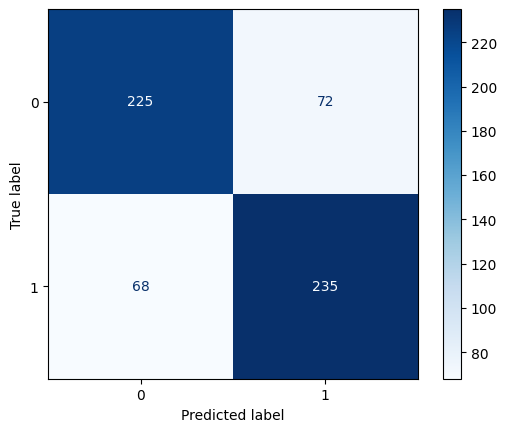

In [80]:
print("Multinomial\n\n", treinar_modelo(comentarios_vetorizados, MultinomialNB()))
#resultado = pd.DataFrame(resultado.values(), index=resultado.keys()).T

              precision    recall  f1-score   support

           0       0.84      0.80      0.82       305
           1       0.80      0.84      0.82       294

    accuracy                           0.82       599
   macro avg       0.82      0.82      0.82       599
weighted avg       0.82      0.82      0.82       599

Multinomial

 {'accuracy_score_5': 0.788313856427379, 'accuracy_score_10': 0.7943054626532888, 'accuracy_score_15': 0.7976432160804021, 'accuracy_score_20': 0.7999821029082774, 'accuracy_score_50': 0.8086610169491526, 'accuracy_score_100': 0.8093103448275863, 'accuracy_score_200': 0.8089761904761904}


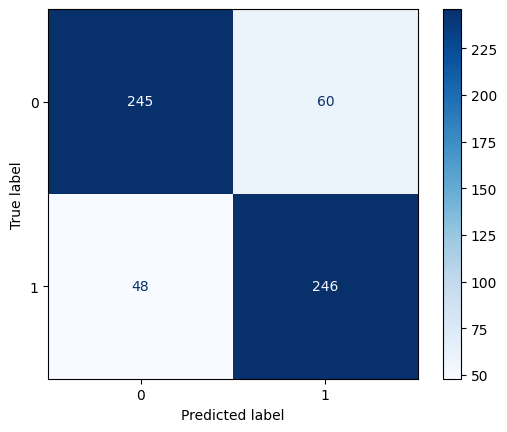

In [81]:
print("Multinomial\n\n", treinar_modelo(comentarios_vetorizados_stemmer, MultinomialNB()))
#resultado_st = pd.DataFrame(resultado_st.values(), index=resultado_st.keys()).T